<a href="https://colab.research.google.com/github/baikunth2a/Lead-Score/blob/master/score_emp_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup Google Drive File System

In [2]:
import pandas as pd
import sys
import os

from google.colab import drive
drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/My Drive/lead_gen')
%cd /content/gdrive/My\ Drive/lead_gen

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/
/content/gdrive/My Drive/lead_gen


#Preprocessing

In [54]:
excel_data = pd.read_excel('send_or_not.xlsx', sheet_name='13k')
excel_data.rename(columns={'SEND/NOT SEND':'send'}, inplace=True)
data_i = excel_data[excel_data['send'].apply(lambda x: x in ['SEND', 'NOT SEND'])]
data_i = data_i[['score', 'no_of_employees', 'send']]

In [55]:
data_i.sample(5)

,score,no_of_employees,send
7098,0.0,0 a 5 personas,NOT SEND
7687,0.0,0 a 5 personas,SEND
3064,0.0,6 a 10 personas,NOT SEND
1649,0.0,6 a 10 personas,SEND
553,1.0,6 a 10 personas,SEND


###Encoding

In [56]:
#one hot
# data = pd.get_dummies(data_i[['score', 'no_of_employees']])
# data['send'] = data_i['send'].astype('category').cat.codes

#Label
# data = pd.DataFrame([data_i[x].astype('category').cat.codes for x in ['no_of_employees', 'score', 'send']])
# data = data.T
# data.columns = ['emp size', 'score', 'send']

#replace
data = data_i.copy()
replace = rep = {"no_of_employees": {"6 a 10 personas": 10, "0 a 5 personas": 5},
                 "send": {"SEND": 1, "NOT SEND": 0}}
data.replace(rep, inplace=True)
data.sample(3)

,score,no_of_employees,send
1177,0.0,10,1
347,3.0,5,1
9908,0.0,5,1


In [57]:
class0 = data_i['send'].astype('category').cat.categories[0]
class1 = data_i['send'].astype('category').cat.categories[1]
labels = [class0, class1]

In [58]:
data.dropna(inplace=True)
data.shape

(1743, 3)

In [59]:
X = data.values[:, :-1].astype(float)
y = data.values[:, -1].astype(float)

In [60]:
X.shape, y.shape

((1743, 2), (1743,))

###Train Test Split

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [62]:
X_train.shape, y_train.shape

((1394, 2), (1394,))

#Logistic Regression Model

In [63]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
y_pred=logreg.predict(X_test)

In [65]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 78,  58],
       [ 38, 175]])

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Text(0.5, 257.44, 'Predicted label')

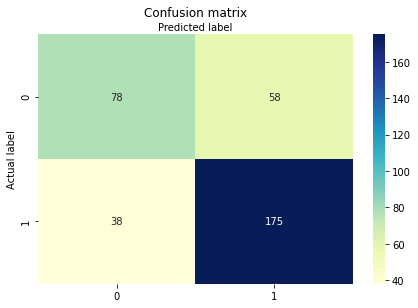

In [67]:
class_names=['send', 'not send'] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names[0])
plt.yticks(tick_marks, class_names[1])
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [68]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.7249283667621776
Precision: 0.7510729613733905
Recall: 0.8215962441314554


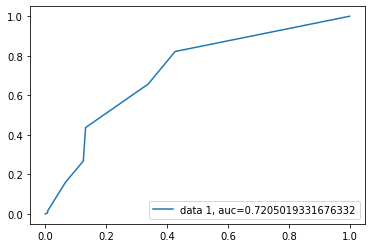

In [69]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

#Decision Tree Classifier

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7249283667621776


In [71]:
labels

['NOT SEND', 'SEND']

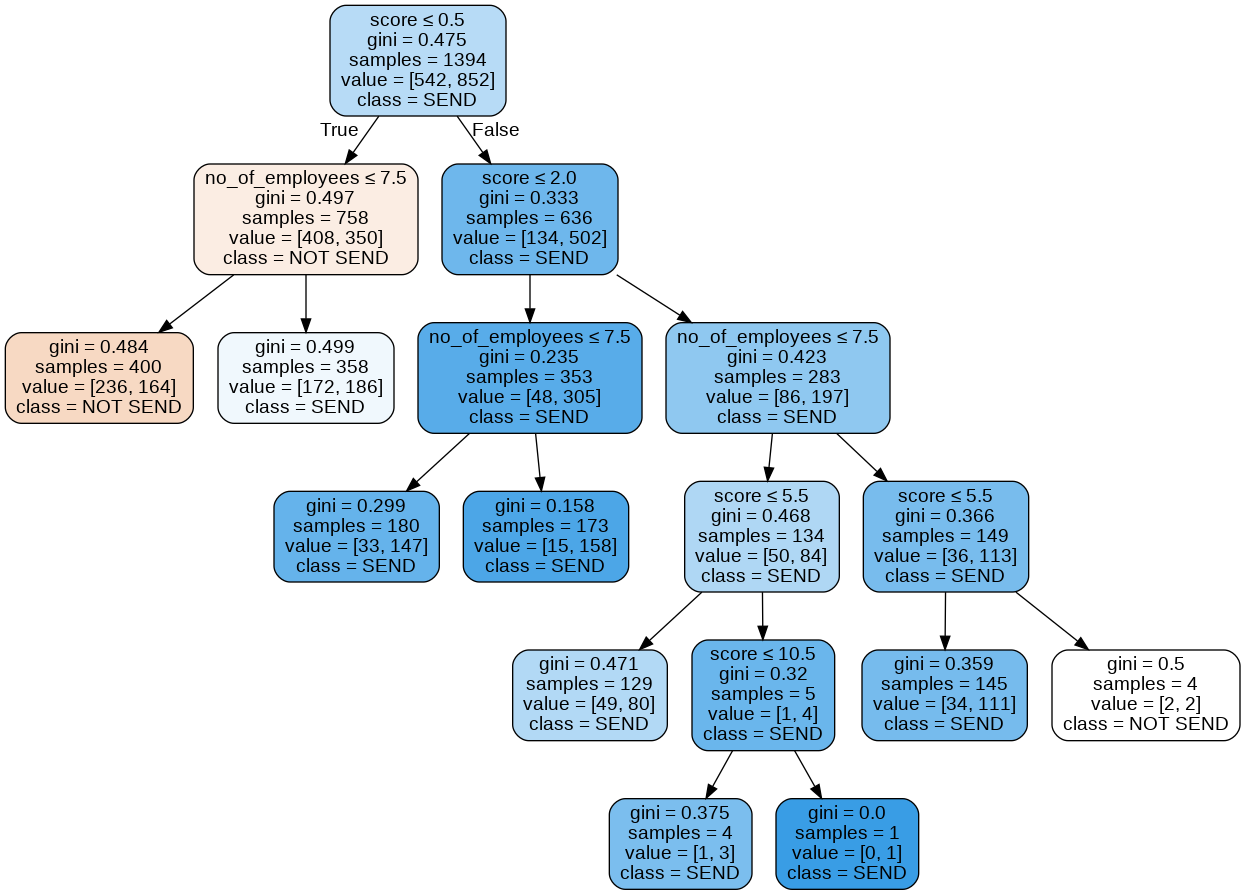

In [73]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = data.columns[:-1],class_names=["NOT SEND", "SEND"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('send_not_send.png')
Image(graph.create_png())